# Testing framework "pipeline"

_Alex Malz (NYU)_

In [1]:
import string
import itertools
import random
import numpy as np
import scipy.stats as sct
import sklearn as skl
from sklearn import metrics
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import proclam
from proclam import *

## 1. True classes

Import the `proclam.Simulator` superclass and the simulator subclass you want to test.  In this notebook, I'm going to use an unbalanced distribution of true classes such that the probability of an object being in class $m$ (with $0 \leq m \leq M$) is proportional to $10^{y}$, where $y$ is a draw from a uniform distribution $U(0,M)$.

In [3]:
from proclam.simulators import simulator
from proclam.simulators import logunbalanced

Create an instantiation of the simulator for the true dataset class distribution scheme.  If you use the base superclass instead of a subclass, the default scheme will be to assign all objects the same class.

In [4]:
A = proclam.simulators.logunbalanced.LogUnbalanced()

Then, simulate a truth catalog.  In this case, there are 3 true classes and 100 objects in the catalog.  The output will be a `numpy.ndarray` with 100 entries, each of which is the index of the class for that catalog member.

In [34]:
A = proclam.simulators.logunbalanced.LogUnbalanced(seed=None)
M_classes = 5
N_objects = 1000
names = [''.join(random.sample(string.ascii_lowercase, 2)) for i in range(M_classes)]
truth = A.simulate(M_classes, N_objects)

We can check that the class distribution is as expected with a histogram of the true classes.

Text(0.5,0,'class')

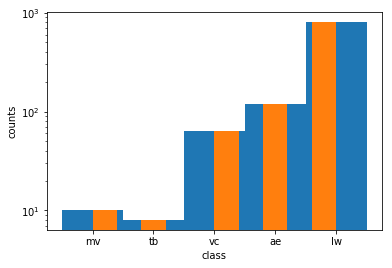

In [35]:
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True)
plt.xticks(range(max(truth)+1), names)

plt.hist(truth, log=True)
plt.ylabel('counts')
plt.xlabel('class')

In [36]:
def save_info(truth, df, name, seed=0):
    pathname = "examples/ProClaM/"+name+"/"
    if os.path.isdir(pathname) == False:
        os.system('mkdir '+ pathname)
    df.to_csv(pathname + "predicted_prob_"+name+".csv", sep=' ', index=False, header=False)
    truth_mask = proclam.metrics.util.det_to_prob(truth)
    fileloc = pathname + 'truth_table_'+name+'.csv'
    np.savetxt(fileloc, truth_mask, delimiter=' ')
    return

## 2. Mock classifications

Import the `proclam.Classifier` superclass and the classifier subclass you want to test.  In this notebook, I'm going to use a very stupid classifier that takes a random guess.

In [37]:
from proclam.classifiers import classifier
from proclam.classifiers import guess
from proclam.classifiers import from_cm

Create an instantiation of the classifier of a particular scheme.  If you use the base superclass instead of a subclass, the default classification scheme will return the true classes.

Then, "classify" the "data."  By default, classification results will also include an extra column for "other" classes beyond the number in the training set, but in this example let's assume it knows of the M classes in the training set without leaving room for additional classes.  The output will be a `numpy.ndarray` with N rows and column entries representing each catalog member's posterior probability for being of each class.

In [38]:
B = proclam.classifiers.guess.Guess(seed=None)
predictionB = B.classify(M_classes, truth, other=False)
save_info(truth, pd.DataFrame(predictionB), 'Guess', seed=0)
# print(prediction)

Let's compare this to a smarter classifier based on a confusion matrix.

[[0.84301939 0.00849486 0.05372158 0.03029484 0.0395269 ]
 [0.00200588 0.77589071 0.04817422 0.10457067 0.04351637]
 [0.09681326 0.08499667 0.68266538 0.04462834 0.13929353]
 [0.13861433 0.06436155 0.1179715  0.63532115 0.13307879]
 [0.01903613 0.00953686 0.0561442  0.05258474 0.83351905]]


Text(0,0.5,'true class')

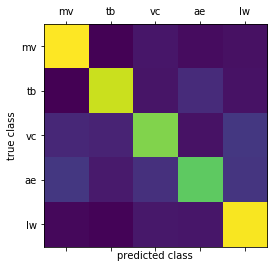

In [39]:
cm = np.eye(M_classes) + 0.2 * np.random.uniform(size=(M_classes, M_classes))
cm /= np.sum(cm, axis=1)
print(cm)
np.flip(cm,0)
plt.matshow(cm)#, vmin=0., vmax=1.)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')

We want to support classifiers with an extra class for classes not represented in the training set, but the infrastructure isn't there yet.

In [40]:
C = proclam.classifiers.from_cm.FromCM(seed=None)
predictionC = C.classify(cm, truth, other=False)
print(predictionC)
save_info(truth, pd.DataFrame(predictionC), 'Idealized', seed=0)

[[0.05535705 0.01162188 0.1849906  0.15811563 0.58991484]
 [0.02979657 0.03519273 0.09063658 0.05025635 0.79411777]
 [0.13134163 0.06565838 0.10990219 0.56275699 0.13034081]
 ...
 [0.02993388 0.02816714 0.06450626 0.07500508 0.80238763]
 [0.03164926 0.01136593 0.0654726  0.0513934  0.84011881]
 [0.03741762 0.01983009 0.07237051 0.05779788 0.8125839 ]]


We can also try this with real data from `SNPhotCC`.

In [41]:
# old_snphotcc_names = []
# for prefix in ['templates_', 'wavelets_']:
#     for suffix in ['boost_forest', 'knn', 'nb', 'neural_network', 'svm']:
#         old_snphotcc_names.append(prefix+suffix+'.dat')

# snphotcc = {}
# snphotcc['label'] = 'SNPhotCC'
# prefixes = ['Templates', 'Wavelets']
# suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
# snphotcc['names'] = []
# for prefix in prefixes:
#     for suffix in suffixes:
#         snphotcc['names'].append(prefix+suffix)
# snphotcc['dirname'] = 'examples/' + snphotcc['label'] + '/'

# truthloc = 'examples/SNPhotCC/key.txt'
# truth_snphotcc = pd.read_csv(truthloc, sep=' ')
# # truth_snphotcc -= 1.
# # truth_snphotcc = truth_snphotcc.astype(int)[:N_objects]
# # truth_snphotcc = pd.DataFrame(truth_snphotcc)

# for i in range(len(snphotcc['names'])):
#     name = old_snphotcc_names[i]
#     fileloc = 'examples/SNPhotCC/classifications/'+name
#     snphotcc_info = pd.read_csv(fileloc, sep=' ')
#     full = snphotcc_info.set_index('Object').join(truth_snphotcc.set_index('Object'))
#     name = snphotcc['names'][i]
    
#     snphotcc_truth = full['Type'] - 1
#     snphotcc_truth_table = proclam.metrics.util.det_to_prob(snphotcc_truth)
#     fileloc = snphotcc['dirname']+name+'/truth_table_'+name+'.csv'
#     np.savetxt(fileloc, snphotcc_truth_table, delimiter=' ')
    
#     probs = full[['1', '2', '3']]
#     fileloc = snphotcc['dirname']+name+'/predicted_prob_'+name+'.csv'
#     probs.to_csv(fileloc, sep=' ', index=False, header=False)

In [42]:
# print(snphotcc_info)
# print(truth_snphotcc)
# print(full)

In [43]:
# probs = np.loadtxt('examples/classifications/templates_knn.dat', usecols=[1, 2, 3], skiprows=1)
# # print(np.shape(probs))
# probs = probs[:N_objects]
# # print(np.shape(probs))

# # truth_snphotcc = np.loadtxt('examples/key.txt', usecols=[1], skiprows=1)
# # truth_snphotcc -= 1.
# # truth_snphotcc = truth_snphotcc.astype(int)[:N_objects]
# # truth_snphotcc = pd.DataFrame(truth_snphotcc)

# CM = proclam.metrics.util.prob_to_cm(probs, truth_snphotcc, vb=True)
# # print(CM)
# plt.matshow(CM)#, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1)[:3], names[:3])
# plt.yticks(range(max(truth)+1)[:3], names[:3])
# plt.xlabel('predicted class')
# plt.ylabel('true class')

# F = proclam.classifiers.from_cm.FromCM(seed=None)
# predictionF = F.classify(CM, truth_snphotcc, other=False)

Below is tunnel vision classifier which means that it performs well on one class only and classifies other classes agnostically so it might classify other classes correctly by chance. The class that is classified correctly is chosen in the code randomly each time.

There are different scenarios for the confusion matrix which are discussed and shown below:

**1) Tunnel classifier CM:** 

This is where the confusion matrix has one class that has a high value on the diagnoal and small value on the off-diagonal elements for that specific class and has small values for the diagonal component of other classes or 1/M value for all entries (classifies y chance)

In [44]:
# N = 3 #len(truth)
# M = len(cm)
#if other: M += 1
CM = np.zeros((M_classes, M_classes))
class_corr = np.array([2]) #np.random.randint(0, M_classes, size=1) # randomly choose which class to work well on

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[class_corr[0]][class_corr[0]] = np.random.uniform(1./M_classes, 1., 1)
        
print(CM)
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMtunnel = CM

# saving probabilities
G           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionG = G.classify(CMtunnel, truth, other=False)
df          = pd.DataFrame(predictionG)
save_info(truth, df, 'Tunnel', seed=0)

[[0.19312237 0.06603181 0.1794948  0.11602441 0.13917013]
 [0.1440843  0.06982315 0.19482636 0.09294267 0.06976791]
 [0.11097536 0.10546086 0.85359456 0.00420068 0.1100092 ]
 [0.05764185 0.0833375  0.18195367 0.14427883 0.1539831 ]
 [0.0445992  0.04727177 0.12427185 0.03547915 0.00758371]]


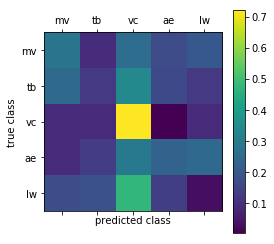

In [45]:
plt.matshow(CMtunnel)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**2) Broadbrush classifier CM:** 

This is where the confusion matrix takes thre most populous class and classifies that one correctly. This is very similar to tunnel classifier except that we kow which class it will classify correctly and it is not randomly chosen.

In [46]:
CM = np.zeros((M_classes, M_classes))
class_corr = sct.mode(truth)[0] #takes the most common class

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[class_corr[0]][class_corr[0]] = np.random.uniform(1./M_classes, 1., 1)
        
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMbroadbrush = CM

# saving probabilities
H           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionH = H.classify(CMbroadbrush, truth, other=False)
df          = pd.DataFrame(predictionH)

save_info(truth, df, 'Broadbrush', seed=0)

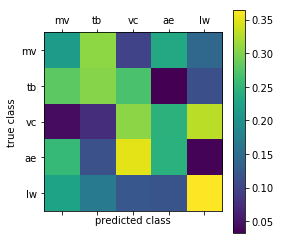

In [47]:
plt.matshow(CMbroadbrush)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**3) Cruise classifier CM:** 

This is where the confusion matrix has high values on the column of one specific class which means that the classifier constantly classifies all entries as one specific class

In [48]:
CM = np.zeros((M_classes, M_classes))
class_corr = 2 #np.random.randint(0, M_classes, size=1) # randomly choose which class to classify all class on

for i in range(M_classes):
    for j in range(M_classes):
        CM[i][j] = np.random.uniform(0., 1./M_classes, 1)
        CM[i][class_corr] = np.random.uniform(1./M_classes, 1., 1)
        
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMcruise = CM

# saving probabilities
I = proclam.classifiers.from_cm.FromCM(seed=None)
predictionI = I.classify(CMcruise, truth, other=False)
df          = pd.DataFrame(predictionI)

save_info(truth, df, 'Cruise', seed=0)

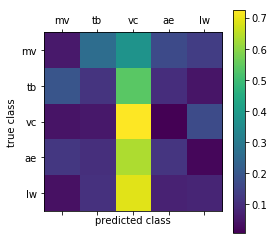

In [49]:
plt.matshow(CMcruise)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

**4) Subsumed classifier CM:** 

This is where the classifier consistently classifies class M and class M'. So, the confusion matrix will have a higher value on the element on row M and column M' compared to other values in that row so that it is misclassified most of the times. Other classes may be classified correctly randomly as I assign them random uniform values between 0 and 1. There could be more restriction on the other classes if we want.

In [50]:
CM = np.zeros((M_classes, M_classes))
class_M      = 1 #np.random.randint(0., M_classes, size=1)[0]
class_Mprime = 2 #np.random.randint(0., M_classes, size=1)[0]

#This is to make sure we do not misclassify class M with the same class (which makes no sense)
n = 0
while class_M == class_Mprime:
    n+=1
    print(("going in to the loop", n, "times!"))
    class_Mprime = np.random.randint(0., M_classes, size=1)

CM = cm.copy()#np.random.uniform(0., 1, 1)
CM[class_M] = CM[class_Mprime]
# for i in range(M_classes):
#     for j in range(M_classes):
#         CM[i][j] = np.random.uniform(0, 1., 1)
#         CM[class_M][class_Mprime]  = np.random.uniform(1./M_classes, 1., 1)

CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMsubsumedto2 = CM

# saving probabilities
J = proclam.classifiers.from_cm.FromCM(seed=None)
predictionJ = J.classify(CMsubsumedto2, truth, other=False)
df          = pd.DataFrame(predictionJ)

save_info(truth, df, 'SubsumedTo', seed=0)

In [51]:
CM = np.zeros((M_classes, M_classes))
class_M      = 2 #np.random.randint(0., M_classes, size=1)[0]
class_Mprime = 3 #np.random.randint(0., M_classes, size=1)[0]

#This is to make sure we do not misclassify class M with the same class (which makes no sense)
n = 0
while class_M == class_Mprime:
    n+=1
    print(("going in to the loop", n, "times!"))
    class_Mprime = np.random.randint(0, M_classes, size=1)[0]
print(class_M, class_Mprime)

# for i in range(M_classes):
#     for j in range(M_classes):
CM = cm.copy()#np.random.uniform(0., 1, 1)
CM[class_M] = CM[class_Mprime]#np.random.uniform(1./M_classes, 1., 1)

# print(CM,np.sum(CM, axis=1)[:, np.newaxis])
CM = CM/np.sum(CM, axis=1)[:, np.newaxis] #normalizing to make sure each row sums to 1
CMsubsumedfrom2 = CM


# saving probabilities
J1           = proclam.classifiers.from_cm.FromCM(seed=None)
predictionJ1 = J1.classify(CMsubsumedfrom2, truth, other=False)
df           = pd.DataFrame(predictionJ1)

save_info(truth, df, 'SubsumedFrom', seed=0)

2 3


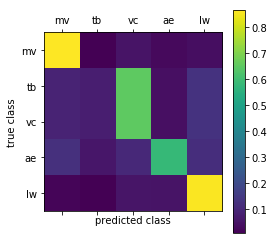

In [52]:
plt.matshow(CMsubsumedto2)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

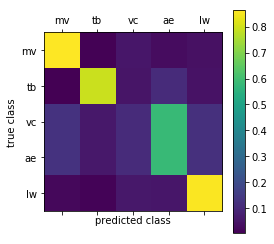

In [53]:
plt.matshow(CMsubsumedfrom2)
plt.xticks(range(max(truth)+1), names)
plt.yticks(range(max(truth)+1), names)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.colorbar()

## 3. Metric values

Import the `proclam.Metric` superclass and the metric subclass you want to test.

In [54]:
from proclam.metrics import metric
from proclam.metrics import logloss
from proclam.metrics import brier

### Probabilistic metrics

Let's try out the [logloss metric](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Cross_entropy_loss).  The logloss metric is a sum over $LL_{ij} = -y_{ij}\ln[p_{ij}]$ for predicted probabilities $p$ and true class indicators $y$.

In [55]:
# weights = np.array([0.3,0.15,0.1,0.15,0.3])
weights = np.array([0.0,0.0,1.0,0.0,0.0])

In [56]:
for candidate in [predictionB, predictionC, predictionG, predictionH, predictionI, predictionJ, predictionJ1]:
    D = proclam.metrics.LogLoss()
    performance = D.evaluate(candidate, truth, averaging=weights)
    print('proclam implementation of log-loss: '+str(performance))
    #alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
    #print('scikit-learn implementation of log-loss: '+str(alternative))

#D = proclam.metrics.LogLoss()
#performance = D.evaluate(predictionF, truth_snphotcc, averaging=weights)
#print('proclam implementation of log-loss: '+str(performance))



proclam implementation of log-loss: 1.8311567347208364
proclam implementation of log-loss: 0.5092476540284548
proclam implementation of log-loss: 0.447886819301812
proclam implementation of log-loss: 1.247109134879068
proclam implementation of log-loss: 0.5035886115487717
proclam implementation of log-loss: 0.4968228907244272
proclam implementation of log-loss: 2.201474936392285


In [57]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto2': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
LL_metric = proclam.metrics.LogLoss()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = LL_metric.evaluate(pred_competitor, truth, averaging='per_class')
    print(candidate_cm+' logloss = '+str(metval))

broadbrush logloss = 1.331420882617475
subsumedto2 logloss = 0.8393810219251856
tunnel logloss = 1.6584983550453298
subsumedfrom logloss = 0.7514995103384955
cruise logloss = 1.96818005726984


In [58]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2,'subsumedfrom': CMsubsumedfrom2}
LL_metric = proclam.metrics.LogLoss()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = LL_metric.evaluate(pred_competitor, truth, averaging=weights)
    print(candidate_cm+' logloss = '+str(metval))

broadbrush logloss = 1.23184891077021
subsumedto logloss = 0.5450234646643234
subsumedfrom logloss = 2.1243698887813633
tunnel logloss = 0.48197328992861316
cruise logloss = 0.48531113974731976


Let's try the [Brier score](https://en.wikipedia.org/wiki/Brier_score#Original_definition_by_Brier) this time.  The multi-class Brier score is $BS = \frac{1}{N}\sum\limits _{t=1}^{N}\sum\limits _{i=1}^{R}(f_{ti}-o_{ti})^2$ for $N$ objects, $R$ classes, predicted probabilities $f$, and $o_{i}$ of 1 for true class $i$ and 0 for other true classes.

First we create an instantiation of the metric.  Then, we calculate the metric value.  For binary classes, we can compare to the implementation in `scikit-learn`.

In [59]:
for candidate in [predictionB, predictionC, predictionG, predictionH, predictionI, predictionJ, predictionJ1]:
    E = proclam.metrics.Brier()
    performance = E.evaluate(candidate, truth)
    print('proclam implementation of Brier score: '+str(performance))
    
    if M_classes == 2:
        skl_truth = proclam.metrics.util.truth_reformatter(truth).T[0]
        alternative = skl.metrics.brier_score_loss(skl_truth, prediction.T[0])
        print('scikit-learn implementation: '+str(alternative))
        
# E = proclam.metrics.brier.Brier()
# performance = E.evaluate(predictionF, truth_snphotcc)
# print('proclam implementation of Brier score: '+str(performance))

proclam implementation of Brier score: 0.17096151935636258
proclam implementation of Brier score: 0.0329336512617202
proclam implementation of Brier score: 0.1578662729956788
proclam implementation of Brier score: 0.1426109337001577
proclam implementation of Brier score: 0.19231331331768742
proclam implementation of Brier score: 0.08294618904831727
proclam implementation of Brier score: 0.07519092278033776


In [60]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
B_metric = proclam.metrics.Brier()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = B_metric.evaluate(pred_competitor, truth, averaging='per_class')
    print(candidate_cm+' Brier = '+str(metval))

broadbrush Brier = 0.14121735792114695
subsumedto Brier = 0.07643345046137637
subsumedfrom Brier = 0.06811299045659404
tunnel Brier = 0.15430568290047153
cruise Brier = 0.1926179493417273


In [61]:
test_cases = {'tunnel': CMtunnel, 'broadbrush': CMbroadbrush, 'cruise': CMcruise, 'subsumedto': CMsubsumedto2, 'subsumedfrom': CMsubsumedfrom2}
B_metric = proclam.metrics.Brier()
for candidate_cm in test_cases.keys():
    competitor = proclam.classifiers.FromCM(seed=None, scheme=candidate_cm)
    pred_competitor = competitor.classify(test_cases[candidate_cm], truth, other=False)
    metval = B_metric.evaluate(pred_competitor, truth, averaging=weights)
    print(candidate_cm+' Brier = '+str(metval))

broadbrush Brier = 0.1376426424584072
subsumedto Brier = 0.04600976344903664
subsumedfrom Brier = 0.2229160249360209
tunnel Brier = 0.036388648635375685
cruise Brier = 0.04010306420811519


### Deterministic metrics

Let's check that reducing the probabilities to class point estimates actually does what we want; the one based on a good confusion matrix should do better than the random guesser.  

In [63]:
from proclam.metrics import util as pmu
from proclam.metrics import roc
from importlib import reload
reload(proclam.metrics.roc)
from proclam.metrics import roc

metric = roc.Metric()
rocB = metric.evaluate(predictionB,truth)
rocC = metric.evaluate(predictionC,truth)

print('AUC for prediction B = %.3f'%rocB)
print('AUC for prediction C = %.3f'%rocC)

rocB = metric.evaluate(predictionB,truth,weights=[0.1,0.3,0.2,0.2,0.2])
print('AUC for prediction B with weird weights = %.3f'%rocB)

# for candidate in [predictionB, predictionC]:
#      intermediate = pmu.prob_to_det(candidate)
#      rates = pmu.det_to_rate(intermediate, truth, vb=False)

#      print('true positives '+str(rates.TPR))
#      print('false negatives'+str(rates.FNR))
    
# intermediate = pmu.prob_to_det(predictionF)
# rates = pmu.det_to_rate(intermediate, truth_snphotcc, vb=False)
# print('true positives '+str(rates.TPR))
# print('false negatives'+str(rates.FNR))

AUC for prediction B = 0.506
AUC for prediction C = 0.997
AUC for prediction B with weird weights = 0.522


# Next steps

Once there are more simulators, classifiers, and metrics, we'll loop over tests and plot comparisons.  Stay tuned for more!

In [ ]:
# Z = proclam.classifiers.guess.Guess(seed=None)
# predictionZ = Z.classify(M_classes, truth, other=False)
# # print(prediction)
# predictionZ

# for candidate in [predictionZ]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# print(type(predictionZ))
# print(predictionZ.shape)

# rows = [0, 1, 30, 50, 62, 60]
# cols = [0, 2, 4, 1, 0, 0]

# ## fill with fake zeros
# predictionZ_0 = predictionZ
# predictionZ_0[rows,cols] = 0
# predictionZ_0

# for candidate in [predictionZ_0]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# print(np.where(predictionZ_0 < 0.000003))

# predictionZ_1 = predictionZ
# predictionZ_1[rows,cols] = 1
# predictionZ_1

# for candidate in [predictionZ_1]:
#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(candidate, truth, averaging='per_item')
#     print('proclam implementation of log-loss: '+str(performance))
# #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
# #     print('scikit-learn implementation of log-loss: '+str(alternative))

# D = proclam.metrics.LogLoss()
# performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
# print('proclam implementation of log-loss: '+str(performance))

# np.where(predictionZ_1 > 0.9995)


In [ ]:
# for i in range(1, 100000):
#     print(i)
#     Z = proclam.classifiers.guess.Guess(seed=i)
#     predictionZ = Z.classify(M_classes, truth, other=False)
#     # print(prediction)
#     predictionZ

#     for candidate in [predictionZ]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     # print(type(predictionZ))
#     # print(predictionZ.shape)

#     rows = [0, 1, 30, 50, 62, 60]
#     cols = [0, 2, 4, 1, 0, 0]

#     ## fill with fake zeros
#     predictionZ_0 = predictionZ
#     predictionZ_0[rows,cols] = 0
#     predictionZ_0

#     for candidate in [predictionZ_0]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     np.where(predictionZ_0 < 0.0005)

#     predictionZ_1 = predictionZ
#     predictionZ_1[rows,cols] = 1
#     predictionZ_1

#     for candidate in [predictionZ_1]:
#         D = proclam.metrics.LogLoss()
#         performance = D.evaluate(candidate, truth, averaging='per_item')
#         # print('proclam implementation of log-loss: '+str(performance))
#     #     alternative = skl.metrics.log_loss(truth, candidate, normalize=True)
#     #     print('scikit-learn implementation of log-loss: '+str(alternative))

#     D = proclam.metrics.LogLoss()
#     performance = D.evaluate(predictionF, truth_snphotcc, averaging='per_item')
#     # print('proclam implementation of log-loss: '+str(performance))

#     np.where(predictionZ_1 == 1)
#     print("ITER :\n",i)
#     i += 1
